In [95]:
!pip install xgboost==3.0.0
!pip install catboost==1.2.7
!pip install shap

In [96]:
import os
import shap
import numpy as np
import pandas as pd
import xgboost as xgb
import catboost as cb
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

shap.initjs()

In [97]:
data = pd.read_csv("data.csv")
data.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1. Разбейте датасет в соотношении 70/30 на обучающую и тестовую выборку.

In [98]:
x_train, x_valid = train_test_split(
    data[['TransactionAmt', 'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1']], train_size=0.70, random_state=1
)
y_train, y_valid = train_test_split(
    data['isFraud'], train_size=0.70, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 70000 rows, 17 cols
x_valid.shape = 30000 rows, 17 cols


2. Обучите алгоритм Catboost в варианте «из коробки» (без доп. настройки параметров) на трейновых данных и посчитайте, какое значение ROC AUC алгоритм выдаёт на тестовой части.

In [100]:
model = cb.CatBoostClassifier(random_state=27)
model.fit(x_train, y_train)

Learning rate set to 0.063211
0:	learn: 0.5862539	total: 9.21ms	remaining: 9.2s
1:	learn: 0.4966339	total: 16.7ms	remaining: 8.33s
2:	learn: 0.4241446	total: 24.5ms	remaining: 8.13s
3:	learn: 0.3657481	total: 31.4ms	remaining: 7.82s
4:	learn: 0.3201356	total: 38.1ms	remaining: 7.58s
5:	learn: 0.2822193	total: 44.4ms	remaining: 7.35s
6:	learn: 0.2538202	total: 51.5ms	remaining: 7.31s
7:	learn: 0.2285387	total: 58.3ms	remaining: 7.23s
8:	learn: 0.2058339	total: 64.8ms	remaining: 7.13s
9:	learn: 0.1871964	total: 71.2ms	remaining: 7.05s
10:	learn: 0.1725755	total: 77.8ms	remaining: 6.99s
11:	learn: 0.1598042	total: 84.3ms	remaining: 6.94s
12:	learn: 0.1498142	total: 90.6ms	remaining: 6.88s
13:	learn: 0.1413870	total: 97.3ms	remaining: 6.85s
14:	learn: 0.1347769	total: 104ms	remaining: 6.81s
15:	learn: 0.1282777	total: 110ms	remaining: 6.78s
16:	learn: 0.1226936	total: 117ms	remaining: 6.75s
17:	learn: 0.1192725	total: 123ms	remaining: 6.73s
18:	learn: 0.1161436	total: 130ms	remaining: 6.69

In [101]:
y_pred = model.predict_proba(x_valid)
score = roc_auc_score(y_valid, y_pred[:, 1])
print(f"score_CatBoost = {round(score, 4)}")

score_CatBoost = 0.9014


3. Аналогичным образом обучите на трейновой части XGBoost «из коробки» и посчитайте значение ROC AUC. Какой алгоритм показал себя лучше в базовом варианте?

In [102]:
baseline = xgb.XGBClassifier(random_state=27)
baseline.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [103]:
y_pred = baseline.predict_proba(x_valid)
score = roc_auc_score(y_valid, y_pred[:, 1])
print(f"score_XGB = {round(score, 4)}")

score_XGB = 0.9128


In [ ]:
score_XGB = 0.9128, score_CatBoost = 0.9014. XGBoost показал себя лучше.

4. При помощи оригинального API попробуйте настроить XGBoost таким образом, чтобы он показал лучшее значение ROC AUC на тестовой части. Измените learning rate, вес регуляризации, количество эпох, параметры дерева… Удалось ли добиться результата лучше, чем Catboost?

In [104]:
xgb_params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.05,
    "reg_lambda": 1,
    "reg_alpha": 0.1,
    "max_depth": 6,
    "nthread": 6,
    "gamma": 5,
    "seed": 27,    
}

dtrain = xgb.DMatrix(
    data=x_train, label=y_train
)
dvalid = xgb.DMatrix(
    data=x_valid, label=y_valid
)

In [105]:
evals_result = {}

model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=1000,
    maximize=True,
    early_stopping_rounds=50,
    evals_result=evals_result,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=25,
    
)

[0]	train-auc:0.81838	valid-auc:0.81145
[25]	train-auc:0.88569	valid-auc:0.86465
[50]	train-auc:0.90657	valid-auc:0.87688
[75]	train-auc:0.91770	valid-auc:0.88358
[100]	train-auc:0.91770	valid-auc:0.88358
[118]	train-auc:0.91770	valid-auc:0.88358


Text(0, 0.5, 'ROC-AUC')

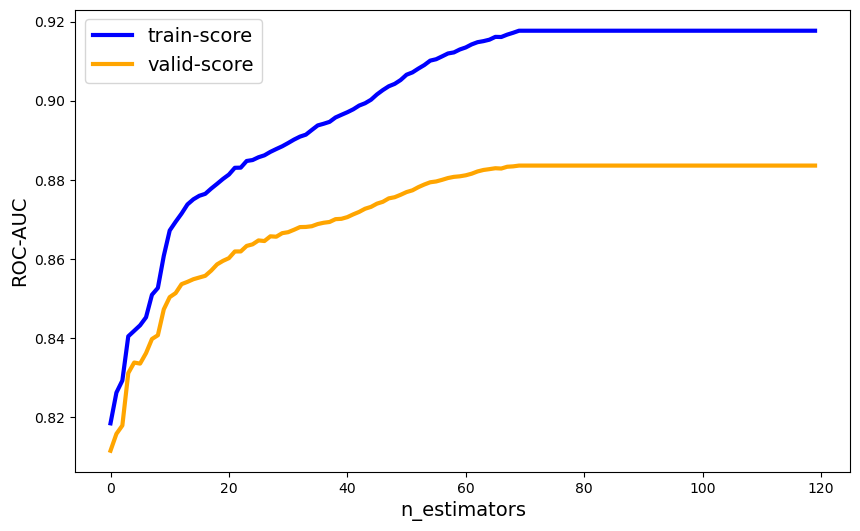

In [106]:
fig = plt.figure(figsize=(10, 6))
plt.plot(evals_result["train"]["auc"], linewidth=3, label="train-score", color="blue")
plt.plot(evals_result["valid"]["auc"], linewidth=3, label="valid-score", color="orange")
plt.legend(loc="best", fontsize=14)
plt.xlabel("n_estimators", size=14)
plt.ylabel("ROC-AUC", size=14)

In [107]:
cv_score = xgb.cv(
    dtrain=dtrain,
    params=xgb_params,
    num_boost_round=1000,
    early_stopping_rounds=50,
    verbose_eval=25,
    maximize=True,
    nfold=5,
)

[0]	train-auc:0.80869+0.01005	test-auc:0.79978+0.00780
[25]	train-auc:0.88438+0.00247	test-auc:0.86632+0.01121
[50]	train-auc:0.90680+0.00211	test-auc:0.88130+0.00892
[75]	train-auc:0.91392+0.00191	test-auc:0.88530+0.00865
[100]	train-auc:0.91392+0.00191	test-auc:0.88530+0.00865
[116]	train-auc:0.91392+0.00191	test-auc:0.88530+0.00865


Text(0, 0.5, 'ROC-AUC')

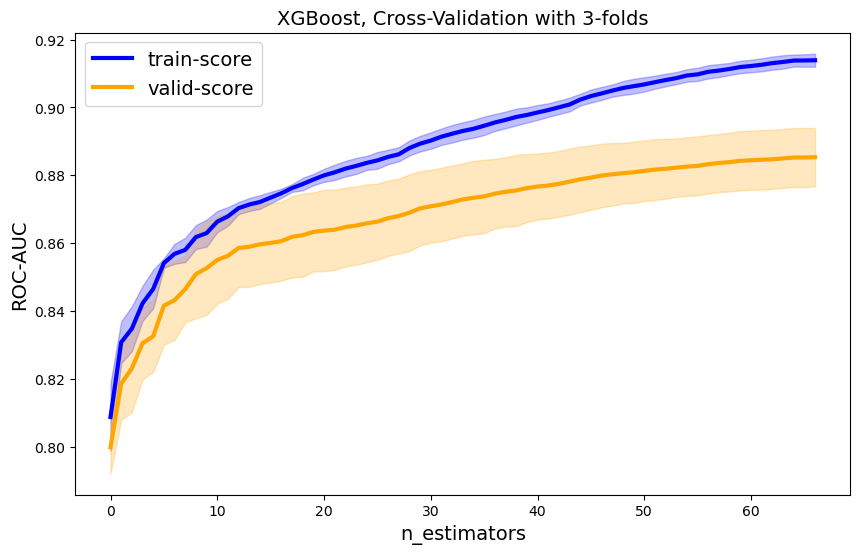

In [108]:
fig = plt.figure(figsize=(10, 6))
plt.title("XGBoost, Cross-Validation with 3-folds", size=14)
plt.plot(
    cv_score["train-auc-mean"],
    label="train-score",
    linewidth=3,
    color="blue"
)
plt.fill_between(
    x=range(cv_score.shape[0]),
    y1=cv_score["train-auc-mean"]-cv_score["train-auc-std"],
    y2=cv_score["train-auc-mean"]+cv_score["train-auc-std"],
    color="blue", alpha=0.25
)
plt.plot(
    cv_score["test-auc-mean"],
    label="valid-score",
    color="orange",
    linewidth=3
)
plt.fill_between(
    x=range(cv_score.shape[0]),
    y1=cv_score["test-auc-mean"]-cv_score["test-auc-std"],
    y2=cv_score["test-auc-mean"]+cv_score["test-auc-std"],
    color="orange", alpha=0.25
)
plt.legend(loc="best", fontsize=14)
plt.xlabel("n_estimators", size=14)
plt.ylabel("ROC-AUC", size=14)

Результат на валидации получился ниже (88,5), чем Catboost (90,14).